In [39]:
using Plots, Colors, LaTeXStrings

In [40]:
using Plots, Plots.Measures
font_title = Plots.font("Arial", 24)
font_axis = Plots.font("Arial", 12)
font_legend = Plots.font("Arial", 8)
pyplot(titlefont=font_title, guidefont = font_axis, legendfont = font_legend)

Plots.PyPlotBackend()

In [41]:
#Define different symbols used in the plotting
delta = latexstring("\$\\delta\$")
micro = latexstring("\$\\mu\$")
vt = latexstring("\$V_t\$")
nt = latexstring("\$N_t\$")
i_ach = latexstring("\$I_{ACh}\$")

v_color = :deepskyblue
n_color = :magenta
c_color = :green
a_color = :purple
b_color = :red
ach_color = :blue

:blue

# RetinalChaos.jl: An introduction
### In order to understand the code published here, these notebooks will act as simple tutorials on both how the model was designed. 

## Table of contents:

### _**[1] Introduction, Motivation, and Components**_
#### [1.1] Voltage and Potassium gating components of the model
#### [1.2] Calcium and the Biochemical Reactions of the sAHP
#### **[1.3] Acetylcholine Diffusion and Dynamics**
#### [1.4] Gaussian White noise and dynamics

### [2] Analyzing Data Output of the model
#### [2.1] Dynamical Analysis
#### [2.2] Fitting Experimental Data (Patch)
#### [2.3] Fitting Experimental Data (Multi-electrode array)
#### [2.4] Fitting Experimental Data (Calcium Imageing) 

### [3] Experiments
#### [3.1] Dual Eye Correlations
#### [3.2] Recapitulations of older papers

### [1.3] Acetylcholine Release, Diffusion, and Activation
- 

In [42]:
import RetinalChaos: read_JSON, extract_dict
import RetinalChaos: T_ode
import RetinalChaos: ODEProblem, solve

In [43]:
figure_path = "C:/users/mtarc/JuliaScripts/RetinalChaos/Notebooks/Figures"

"C:/users/mtarc/JuliaScripts/RetinalChaos/Notebooks/Figures"

In [44]:
p_dict = read_JSON("params.json") 
p_dict[:I_app] = 2.0
p_dict[:D] = 0.01
p = p_dict |> extract_dict;
u0 = read_JSON("conds.json") |> extract_dict;
dt = 1.0
tspan = (0.0, 60e3);

In [45]:
prob = ODEProblem(T_ode, u0, tspan, p)
println("Time it took to simulate 60s:")
@time sol = solve(prob, abstol = 2e-2, reltol = 2e-2, maxiters = 1e7, saveat = dt); 

Time it took to simulate 60s:
  2.472640 seconds (7.87 M allocations: 381.978 MiB, 1.85% gc time)


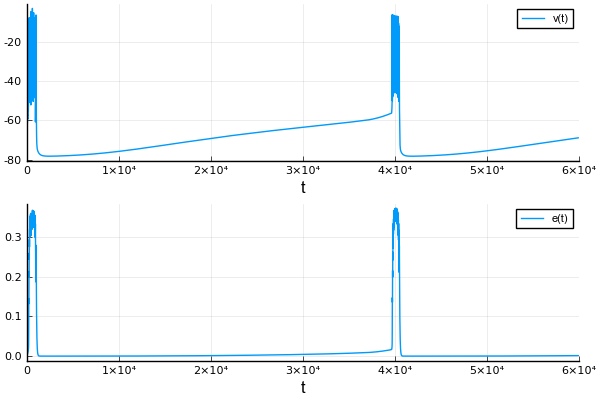

In [46]:
plot(sol, vars = [:v, :e], layout = grid(2, 1))

In [47]:
import RetinalChaos.Φ
v_rng = LinRange(-90.0, 10.0, 100);
AChi = 0.0
ρ = p_dict[:ρ]
k = p_dict[:k]
println(k)
V0 = p_dict[:V0]
τACh = p_dict[:τACh]
fach(v) = (ρ * Φ(v, k, V0)) - (AChi)/τACh
ACh_rng = map(fach, v_rng);

0.2


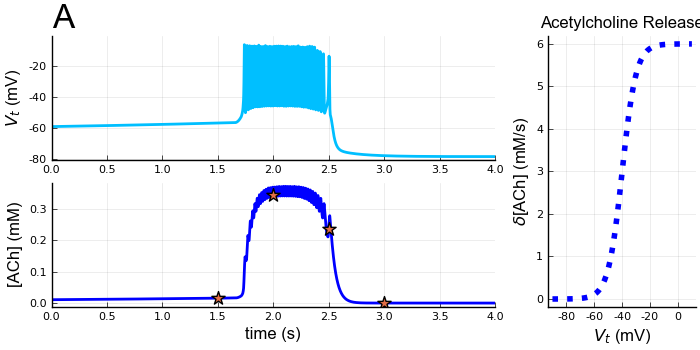

In [70]:
xlims = (38e3, 42e3) 
xticks = (collect(xlims[1]:500:xlims[2]), collect(0:0.5:round(Int, tspan[end]/1000)))

fig2_Aa = plot(sol, 
    vars = [:v, :e], 
    ylabel = ["$(vt) (mV)" "[ACh] (mM)"], 
    xlabel = ["" "time (s)"], 
    c = [v_color ach_color], lw = 2.0,
    legend = :none, 
    layout = grid(2, 1), 
    xlims = xlims, 
    xticks = xticks
)
frame_stops = [1.5e3, 2.0e3, 2.5e3, 3.0e3]
frame_stops .+= xlims[1]
ach_stops = map(t->sol(t)[6], frame_stops)
plot!(fig2_Aa[2], frame_stops, ach_stops, label = "Frame stops",
    seriestype = :scatter, marker = :star, markersize = 10.0)

fig2_Ab = plot(v_rng, ACh_rng, 
    c = ach_color, linestyle = :dot, lw = 4.0, 
    title = "Acetylcholine Release", titlefontsize = 12.0,
    xlabel = "$(vt) (mV)",ylabel = "$(delta)[ACh] (mM/s)", label = "")

fig2_A = plot(fig2_Aa, fig2_Ab, 
    layout = grid(1, 2, widths = [0.75, 0.25]), size = (700, 350))
title!(fig2_A[1], "A", titlepos = :left)

In [71]:
import RetinalChaos: Network, RetinalChaos.diffuse

In [72]:
nx, ny = (50, 50)
c1x, c1y = (round(Int, nx/2), round(Int, ny/4))
c2x, c2y = (round(Int, nx/2), round(Int, ny/4*3))
D = p_dict[:D]
lattice = zeros(nx, ny)
lattice[c1x, c1y] = 0.6
bp_model = Network(nx, ny)

(::Network{Array{Float64,2},:gACh}) (generic function with 1 method)

In [73]:
time_range = collect(0:(xlims[end]-xlims[1]))
println(length(time_range))
lattice_c = zeros(nx, ny, length(time_range))
for (idx, t) in enumerate(time_range)
    #Each step, the cell releases 0.005 ACh
    if idx == 1
        lattice_c[c1x, c1y, idx] = sol(t+xlims[1])[6]
    else
        lattice_c[:, :, idx] = diffuse(lattice_c[:,:,idx-1], D, bp_model)
        lattice_c[c1x, c1y, idx] = sol(t+xlims[1])[6]
    end
end

4001


In [85]:
fig2_B = plot(xlims = (0, nx), ylims = (0, ny), layout = grid(1, length(frame_stops)), size = (1000, 250), 
    margin = 1mm
)
upper_lim = 0.08
for (idx, frame) in enumerate(frame_stops)
    frame_idx = Int(frame-xlims[1])
    #p = plot(xlims = (0.1, nx), ylims = (0.1, ny), 
    #    xaxis = false, yaxis = false)
    if idx == length(frame_stops)
        heatmap!(fig2_B[idx], lattice_c[:,:,frame_idx], c = :thermal, clims = (0.0, upper_lim), 
            aspect_ratio = :equal, grid = false,
            xaxis = false, yaxis = false
        )
        scatter!(fig2_B[idx], [c1y], [c1x], marker = :hexagon, m = (125.0, :transparent, stroke(3.0, :cyan)), label = "")
        scatter!(fig2_B[idx], [c1y], [c1x], marker = :circle, c = :cyan, markersize = 10.0, label = "")
        scatter!(fig2_B[idx], [c2y], [c2x], marker = :hexagon, m = (125.0, :transparent, stroke(3.0, :red)), label = "")
        scatter!(fig2_B[idx], [c2y], [c2x], marker = :circle, c = :red, markersize = 10.0, label = "")
        annotate!(fig2_B[idx], [40], [3], "t = $(time_range[frame_idx+1]/1000)s", :white)
    else
        heatmap!(fig2_B[idx], lattice_c[:,:,frame_idx], c = :thermal, clims = (0.0, upper_lim), 
            aspect_ratio = :equal, grid = false, colorbar = false, 
            xaxis = false, yaxis = false
        )
        scatter!(fig2_B[idx], [c1y], [c1x], marker = :hexagon, m = (125.0, :transparent, stroke(3.0, :cyan)), label = "")
        scatter!(fig2_B[idx], [c1y], [c1x], marker = :circle, c = :cyan, markersize = 10.0, label = "")
        scatter!(fig2_B[idx], [c2y], [c2x], marker = :hexagon, m = (125.0, :transparent, stroke(3.0, :red)), label = "")
        scatter!(fig2_B[idx], [c2y], [c2x], marker = :circle, c = :red, markersize = 10.0, label = "")
        annotate!(fig2_B[idx], [40], [3], "t=$(time_range[frame_idx+1]/1000)s", :white)
    end
end
fig2_B
title!(fig2_B[1], "B", title_pos = :left);

In [81]:
import RetinalChaos.ħ
ach_rng = LinRange(0.0, 0.5, 100)
k_d = p_dict[:k_d]
println(k_d)
g_ACh = p_dict[:g_ACh]
println(g_ACh)
E_ACh = p_dict[:E_ACh]
println(E_ACh)
i_rng = map(a -> -g_ACh*ħ(a, k_d)*(-70.0-E_ACh), ach_rng);

ach_external = lattice_c[c1x, c1y+1, :];
i_synaptic = map(a -> -g_ACh*ħ(a, k_d)*(-70.0-E_ACh), ach_external);

0.1
1.1
0.0


In [82]:
fig2_Ca = plot(layout = (2,1))
plot!(fig2_Ca[1], sol, vars = [:e], c = :blue, label = "Cell 1 release",
    xlims = xlims, 
    xticks = xticks, 
    ylabel = "[ACh] (mM)",
    xlabel = ""
)
plot!(fig2_Ca[1], time_range.+xlims[1], ach_external, label = "Cell 2 Extracellular", 
    c = :red, lw = 3.0, legend = :topleft)

ach_rel = map(t->sol(t)[6], frame_stops)
ach_ext = map(t->lattice_c[c1x, c1y+1, Int(t-xlims[1])], frame_stops)
plot!(fig2_Ca[1], frame_stops, ach_rel, label = "",
    seriestype = :scatter, marker = :star, markersize = 10.0)
plot!(fig2_Ca[1], frame_stops, ach_ext, label = "",
    seriestype = :scatter, marker = :star, markersize = 10.0)

plot!(fig2_Ca[2], time_range./1000.0, i_synaptic, label = "", 
    c = :purple, lw = 2.0,
    ylabel = "$(i_ach) (pA)", xlabel = "time (s)"
)


fig2_Cb = plot(ach_rng, i_rng, label = "",
    xlabel = "Extracellular [ACh] (mM)", ylabel = "$(i_ach) (pA)", 
    title = "Induced $(i_ach)", titlefontsize = 12.0, 
    c = :green, lw = 3.0, 
)
fig2_C = plot(fig2_Ca, fig2_Cb, layout = grid(1,2, widths = [0.75, 0.25]))
title!(fig2_C[1], "C", titlepos = :left);

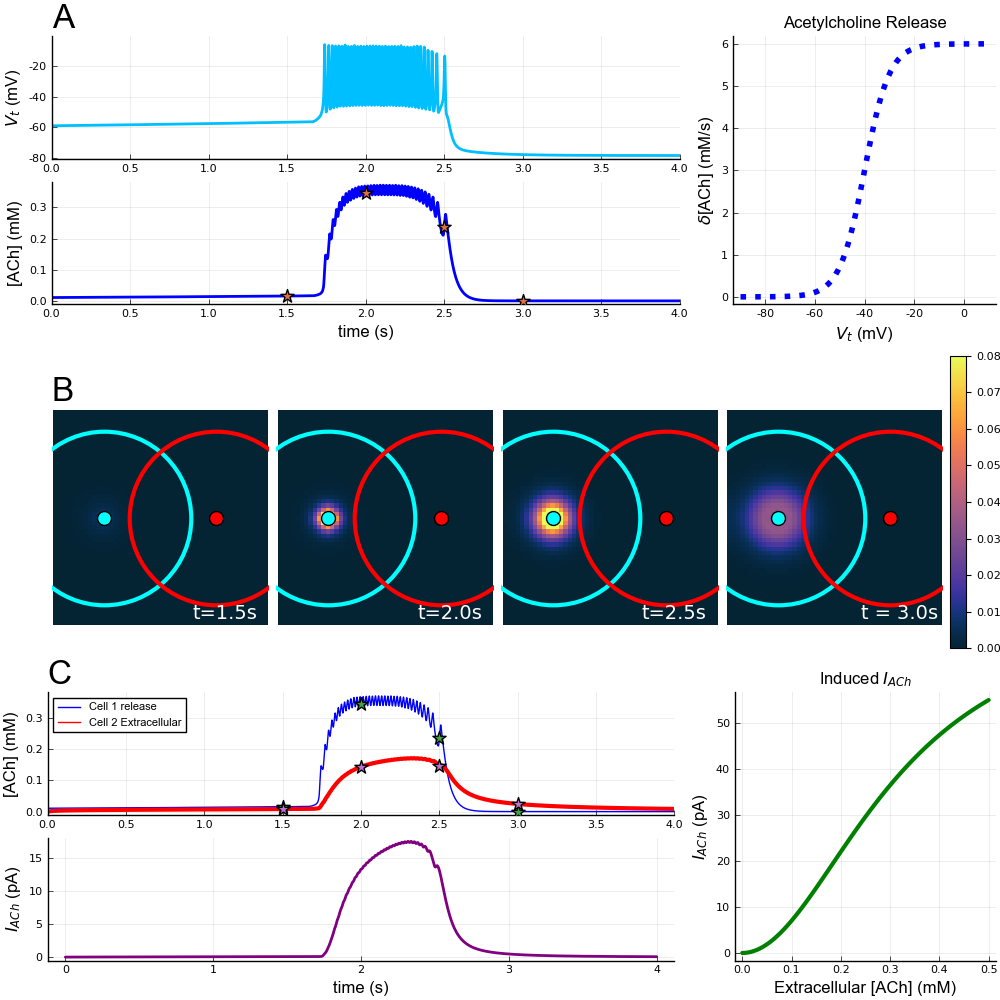

In [83]:
fig2 = plot(fig2_A, fig2_B, fig2_C, layout = grid(3, 1), size = (1000,1000))

In [84]:
savefig(fig2, "$(figure_path)/Figure2_Acetylcholine_Rel_Diff_Activate.png")

### Supplemental Gif 1

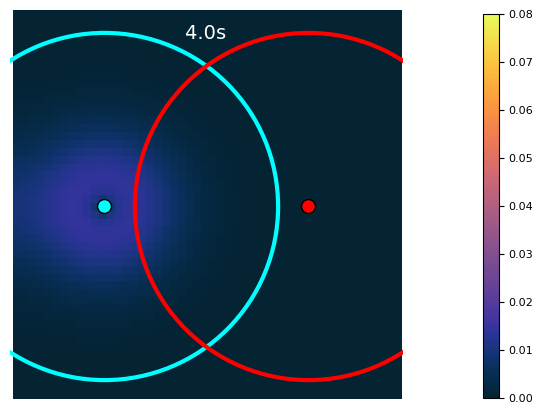

┌ Info: Saved animation to 
│   fn = C:\users\mtarc\JuliaScripts\RetinalChaos\Notebooks\Figures\Supplemental_Video1.gif
└ @ Plots C:\Users\mtarc\.julia\packages\Plots\FYxdA\src\animation.jl:104


Plots.AnimatedGif("C:\\users\\mtarc\\JuliaScripts\\RetinalChaos\\Notebooks\\Figures\\Supplemental_Video1.gif")
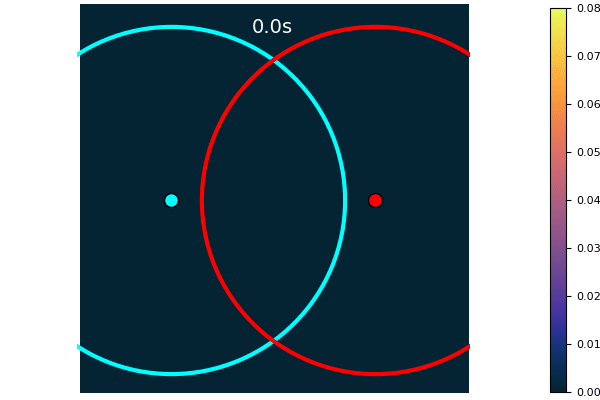

In [62]:
anim = @animate for i = 1:100:size(lattice_c, 3)
    p = plot(xlims = (0.1, nx), ylims = (0.1, ny), 
        xaxis = false, yaxis = false)
    heatmap!(p, lattice_c[:,:,i], c = :thermal, clims = (0.0, upper_lim), aspect_ratio = :equal, grid = false)
    scatter!(p, [c1y], [c1x], marker = :hexagon, m = (250.0, :transparent, stroke(3.0, :cyan)), label = "")
    scatter!(p, [c1y], [c1x], marker = :circle, c = :cyan, markersize = 10.0, label = "")
    scatter!(p, [c2y], [c2x], marker = :hexagon, m = (250.0, :transparent, stroke(3.0, :red)), label = "")
    scatter!(p, [c2y], [c2x], marker = :circle, c = :red, markersize = 10.0, label = "")
    annotate!(p, [c2x], [nx-3], "$(time_range[i]/1000)s", :white)
end
gif(anim, "$(figure_path)/Supplemental_Video1.gif", fps = 60)

### Noise Is explained in another sheet. Before Acetylcholine Diffusion can make sense though, noise must be added. 